In [2]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
from dPCA import dPCA
from get_utils import get_data
import numpy as np
import plot as plot
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#%matplotlib widget
#%matplotlib qt
%matplotlib inline

In [68]:
folder_name = 'Sim_all'
model_name = 'model{:02d}'.format(0)


# Load data
phase = {'NF1':[0],'FF1':[8],'NF2':[0],'FF2':[8]}
U = get_data(folder_name,model_name,phase,ff_coef=None)
data = []
for i in range(len(U)):
    data.append(np.array(U[i]['all_hidden'])) # size: n_trials x n_timepoints x n_neurons   (8, 100, 128)

X = np.concatenate([d[:,None,:,:] for d in data[:2]], axis=1)
X = X.transpose(3,0,1,2) # neurons x conditions x phase x time
X = X - np.mean(X, axis=(1,2,3))[:,None,None,None]

X_1 = X[:,:,:2,:]

# Fit
dpca = dPCA.dPCA(labels='clt',join={'ct':['c','ct'], 'lt':['l','lt'], 'clt':['cl','clt']}, n_components=6) # {'ct':['c','ct'], 'lt':['l','lt'], 'clt':['cl','clt']}    {'c':['c'],'l':['l'], 't':['t'],'lt':['lt']}
dpca.protect = ['t']
Z = dpca.fit_transform(X_1)

Text(0, 0.5, 'Ratio of explained variance')

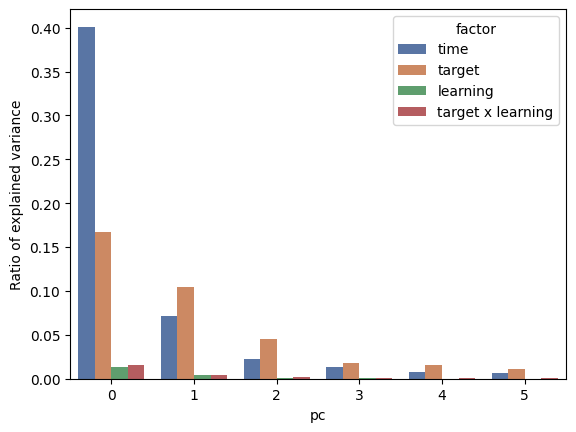

In [69]:
names = ['time','target','learning','target x learning']
var = dpca.explained_variance_ratio_
var_df = pd.DataFrame(columns=['factor', 'pc', 'variance_explained'])

counter = 0
for i,name in enumerate(var.keys()):
    for c in range(dpca.n_components):
        var_df.loc[counter] = {'factor': names[i], 'pc': c, 'variance_explained': var[name][c]}
        counter += 1

# Plot
fig,ax = plt.subplots()
sns.barplot(var_df, x='pc', y='variance_explained', hue='factor', palette=sns.color_palette('deep',4))
ax.set_ylabel('Ratio of explained variance')

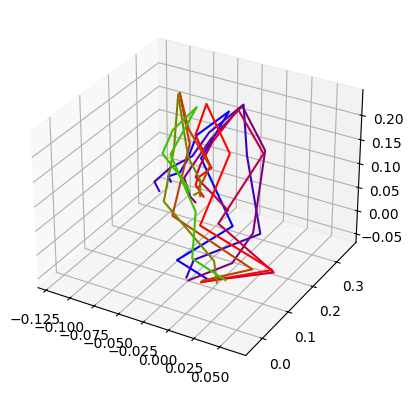

In [72]:
# neurons x conditions x phase x time
x_1 = Z['lt'][:,:,0,:].transpose(1,2,0)
x_2 = Z['lt'][:,:,1,:].transpose(1,2,0)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


plot.plot_traj(ax,[x_1],which_times=list(range(0,10)),plot_scatter=0,dim=3)